In [0]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from collections import Counter
import statsmodels.api as sm
from scipy.stats import f
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
% matplotlib inline

### Data processing

Extract data from Johns Hopkins (aggregated data from WHO daily reports)

In [0]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(url)

Select only territories inside the US (drop Puerto Rico and etc.) and delete unnesessary fields

In [0]:
data = data[data['iso2'] == 'US']

In [0]:
del data['UID']
del data['iso2']
del data['iso3']
del data['code3']
del data['FIPS']
del data['Country_Region']
del data['Lat']
del data['Long_']

In [0]:
data.head()

,Admin2,Province_State,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
5,Autauga,Alabama,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26,26,25,26,28,30,32,33,36,36,37,39,40,43,44,42,45,48,53,53,58,61,67,68,74,84,91,93,104,103,110,110,120,127,136,143,149,155,159,168
6,Baldwin,Alabama,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216,222,224,227,231,243,244,254,254,260,262,270,269,271,273,274,274
7,Barbour,Alabama,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,15,18,20,22,28,29,30,32,32,33,35,37,37,39,42,43,45,45,47,47,51,53,58,59,61,67,69,74,79,79,81,85,90,96,99,104,105,110,113
8,Bibb,Alabama,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,22,24,26,28,32,32,34,33,34,34,38,42,42,42,42,42,42,43,42,43,43,44,44,45,46,46,46,46,46,49,50,50,50,51,52,52,55,58,59,59
9,Blount,Alabama,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18,20,20,21,22,26,29,31,31,31,34,34,34,36,37,39,40,40,40,40,42,44,44,44,44,45,45,45,45,45,45,46,47,47,47,47,49,49,49,49


Select only counties with >0 cases

In [0]:
data = data[data['5/25/20'] != 0]   #check last column name

In [0]:
data[data['Admin2'] == 'Presidio']

,Admin2,Province_State,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
2716,Presidio,Texas,"Presidio, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Create new dataframe with delta cases per date. Join with county population table.

In [0]:
data_deltas = pd.DataFrame(data[['Admin2', 'Province_State', 'Combined_Key']])
for i in range(4,len(data.columns)):     #check index with df form
  data_deltas[data.columns[i]] = data[data.columns[i]] - data[data.columns[i-1]]

In [0]:
data_deltas.rename(columns={'Admin2':'County'}, inplace=True)

In [0]:
data_deltas.head()

,County,Province_State,Combined_Key,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
5,Autauga,Alabama,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,-1,1,2,2,2,1,3,0,1,2,1,3,1,-2,3,3,5,0,5,3,6,1,6,10,7,2,11,-1,7,0,10,7,9,7,6,6,4,9
6,Baldwin,Alabama,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,2,6,3,5,6,9,11,4,0,14,7,3,3,0,1,6,6,1,1,7,9,3,8,6,2,3,4,12,1,10,0,6,2,8,-1,2,2,1,0
7,Barbour,Alabama,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,1,3,2,2,6,1,1,2,0,1,2,2,0,2,3,1,2,0,2,0,4,2,5,1,2,6,2,5,5,0,2,4,5,6,3,5,1,5,3
8,Bibb,Alabama,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,2,2,2,4,0,2,-1,1,0,4,4,0,0,0,0,0,1,-1,1,0,1,0,1,1,0,0,0,0,3,1,0,0,1,1,0,3,3,1,0
9,Blount,Alabama,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,0,1,1,4,3,2,0,0,3,0,0,2,1,2,1,0,0,0,2,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,2,0,0,0


### Population

Source: US Census

In [0]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/population_counties.csv', sep=';', decimal=',')

In [0]:
data_pop = data_deltas.join(df_pop.set_index('County'), on='County', how='left')

In [0]:
del data_pop['Combined_Key']

In [0]:
data_pop.head()

,County,Province_State,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,Population
5,Autauga,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,-1,1,2,2,2,1,3,0,1,2,1,3,1,-2,3,3,5,0,5,3,6,1,6,10,7,2,11,-1,7,0,10,7,9,7,6,6,4,9,NaN
6,Baldwin,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,6,3,5,6,9,11,4,0,14,7,3,3,0,1,6,6,1,1,7,9,3,8,6,2,3,4,12,1,10,0,6,2,8,-1,2,2,1,0,NaN
7,Barbour,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,2,2,6,1,1,2,0,1,2,2,0,2,3,1,2,0,2,0,4,2,5,1,2,6,2,5,5,0,2,4,5,6,3,5,1,5,3,NaN
8,Bibb,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,4,0,2,-1,1,0,4,4,0,0,0,0,0,1,-1,1,0,1,0,1,1,0,0,0,0,3,1,0,0,1,1,0,3,3,1,0,NaN
9,Blount,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,1,1,4,3,2,0,0,3,0,0,2,1,2,1,0,0,0,2,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,2,0,0,0,NaN


In [0]:
data_pop = data_pop[data_pop['Population'].isnull() == False]

Create a dataframe containing daily new cases per person (deltas divided by population).

In [0]:
data_deltas_rel = pd.DataFrame(data_pop['County'])
for i in range(data_pop.shape[1] - 2):
    data_deltas_rel[data_pop.columns[i]] = data_pop[data_pop.columns[i]]/data_pop['Population']

Create a list containing trimmed sequences of relative deltas. They will have different lengths and can't be stored in a pd.DataFrame or an np.array. Store only counties with more then 50% values not 0.

In [0]:
lst = []
for i in range(data_deltas_rel.shape[0]):
    county_trimmed = [data_deltas_rel.iloc[i,0]] + list(np.trim_zeros(data_deltas_rel.iloc[i,1:]))
    if county_trimmed.count(0.0)/len(county_trimmed) <= 0.5:
        lst.append(county_trimmed)

### Population Density

Source: US Census (https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND)

In [0]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/population_counties.csv', sep=';', decimal=',')

In [0]:
county_area = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/counties_area.csv', sep=";")

Source: USPS (https://pe.usps.com/text/pub28/28apb.htm). A dictionary mapping for 2-letter state names

In [0]:
state_2l = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/states_2l.csv', sep=';')
st_2l_d = dict(zip(state_2l.iloc[:,0], state_2l.iloc[:,1]))

Transform combined county names to format with 2-letter states

In [0]:
tmp = np.transpose([i.split(', ') for i in df_pop['County']])
df_pop['County'] = tmp[0]
df_pop['State'] = [st_2l_d[i] for i in tmp[1]]

In [0]:
df_pop['County'] = df_pop['County'] + ', ' + df_pop['State']

Join tables with population and area data to calculate population density

In [0]:
county_area.rename(columns={'Areaname':'County'}, inplace=True)

In [0]:
df_pop = df_pop.join(county_area.set_index('County'), on='County', how='left')

In [0]:
df_pop['Population Density'] = df_pop['Population']/df_pop['LND110210D']
del df_pop ['Population']
del df_pop['LND110210D']
del df_pop['STCOU']
del df_pop['State']

Transform data_deltas to the same key format as in population density table

In [0]:
data_deltas = data_deltas[data_deltas['Province_State'].isin(st_2l_d.keys())]
data_deltas['State'] = [st_2l_d[i] for i in data_deltas['Province_State']]
del data_deltas['Province_State']
data_deltas['County'] = data_deltas['County'] + ', ' + data_deltas['State']
del data_deltas['Combined_Key']
del data_deltas['State']

Join data_deltas table with population density one to create a time series of deltas divided by population density

In [0]:
data_dens = data_deltas.join(df_pop.set_index('County'), on='County', how='left')

In [0]:
data_deltas_rel = pd.DataFrame(data_dens['County'])
for i in range(1, data_dens.shape[1] - 1):
    data_deltas_rel[data_dens.columns[i]] = data_dens[data_dens.columns[i]]/data_dens['Population Density']

Replace negative values with their absolutes, assuming there was a mistake in collecting/processing

In [0]:
data_deltas_rel.iloc[:,1:] = data_deltas_rel.iloc[:,1:].abs()

In [0]:
data_deltas_rel.head()

,County,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20
5,"Autauga, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010640,0.021280,0.000000,0.010640,0.010640,0.021280,0.021280,0.021280,0.010640,0.031920,0.0,0.010640,0.021280,0.010640,0.031920,0.010640,0.021280,0.031920,0.031920,0.053199,0.000000,0.053199,0.031920,0.063839,0.010640,0.063839,0.106399,0.074479,0.021280,0.117039,0.010640,0.074479,0.000000,0.106399,0.074479,0.095759,0.074479,0.063839,0.063839,0.042560
6,"Baldwin, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028486,0.071216,0.014243,0.042730,0.021365,0.035608,0.042730,0.064094,0.078337,0.028486,0.0,0.099702,0.049851,0.021365,0.021365,0.000000,0.007122,0.042730,0.042730,0.007122,0.007122,0.049851,0.064094,0.021365,0.056973,0.042730,0.014243,0.021365,0.028486,0.085459,0.007122,0.071216,0.000000,0.042730,0.014243,0.056973,0.007122,0.014243,0.014243,0.007122
7,"Barbour, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035845,0.071691,0.035845,0.107536,0.071691,0.071691,0.215073,0.035845,0.035845,0.071691,0.0,0.035845,0.071691,0.071691,0.000000,0.071691,0.107536,0.035845,0.071691,0.000000,0.071691,0.000000,0.143382,0.071691,0.179227,0.035845,0.071691,0.215073,0.071691,0.179227,0.179227,0.000000,0.071691,0.143382,0.179227,0.215073,0.107536,0.179227,0.035845,0.179227
8,"Bibb, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027801,0.111205,0.055602,0.055602,0.055602,0.111205,0.000000,0.055602,0.027801,0.027801,0.0,0.111205,0.111205,0.000000,0.000000,0.000000,0.000000,0.000000,0.027801,0.027801,0.027801,0.000000,0.027801,0.000000,0.027801,0.027801,0.000000,0.000000,0.000000,0.000000,0.083404,0.027801,0.000000,0.000000,0.027801,0.027801,0.000000,0.083404,0.083404,0.027801
9,"Blount, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011150,0.011150,0.022301,0.000000,0.011150,0.011150,0.044601,0.033451,0.022301,0.000000,0.0,0.033451,0.000000,0.000000,0.022301,0.011150,0.022301,0.011150,0.000000,0.000000,0.000000,0.022301,0.022301,0.000000,0.000000,0.000000,0.011150,0.000000,0.000000,0.000000,0.000000,0.000000,0.011150,0.011150,0.000000,0.000000,0.000000,0.022301,0.000000,0.000000


Create a list of time series for linear regressions:
1) trim zeros on the left
2) find the sequence of max length
3) pad all the other sequences with zeros from the left to the length of maximal (in order to build common model for several series)

In [0]:
lst = []
names = []
for i in range(data_deltas_rel.shape[0]):
    county_trimmed = list(np.trim_zeros(data_deltas_rel.iloc[i,1:], 'f'))
    if county_trimmed.count(0.0)/len(county_trimmed) <= 0.5:
        names.append(data_deltas_rel.iloc[i,0])
        lst.append(county_trimmed)
l = max([len(i) for i in lst])
for i in range(len(lst)):
    lst[i] = [names[i]] + list(np.pad(lst[i], (l - len(lst[i]), 0)))

### Linear regressions

Build linear regression models for each county. Take maximal polynomial degree = 4. Include features stepwise, using partial F-test as significance criterion.

In [0]:
lr_lst = []
county_lst = []
x_lst = []
ypr_lst = []
for i in range(len(lst)):
    y = np.array(lst[i])[1:].astype('float32')
    y_mean = np.mean(y)
    jb_test = sm.stats.stattools.jarque_bera(y)   #check normality of data
    if jb_test[1] < 0.1:
        x_range = np.array(range(len(y)))
        x_range2 = np.array(range(len(y)))**2
        x_range3 = np.array(range(len(y)))**3
        x_range4 = np.array(range(len(y)))**4
        x = [x_range, x_range2, x_range3, x_range4]
        x1 = sm.add_constant(np.transpose(x[:1]))
        lr_fin = sm.OLS(y, x1).fit()
        for j in range(1, 4):
            lr0 = lr_fin
            x0 = x1
            y_pr0 = lr0.predict(x0)
            ssr0 = sum((y_pr0 - y_mean)**2)
            x1 = sm.add_constant(np.transpose(x[:j+1]))
            lr1 = sm.OLS(y, x1).fit()
            y_pr1 = lr1.predict(x1)
            ssr1 = sum((y_pr1 - y_mean)**2)
            ssr_new = ssr1 - ssr0
            mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
            if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
                y_pr = y_pr0
                x_fin = x0
                break
            y_pr = y_pr1
            x_fin = x1
            lr_fin = lr1          #check residuals for normality and abscence of heteroskedasticity
        if sm.stats.stattools.jarque_bera(lr_fin.resid)[1] < 0.1 and het_breuschpagan(lr_fin.resid, sm.add_constant(np.transpose(x[:len(lr_fin.params)-1])))[-1] < 0.1:
            county_lst.append(lst[i][0])       #save model if it passes the tests
            lr_lst.append(lr_fin)
            ypr_lst.append(y_pr)
            x_lst.append(x_fin)

In [0]:
len(county_lst)

972

In [0]:
p = max([len(reg.params) for reg in lr_lst]) - 1
params = pd.DataFrame([np.pad(reg.params, (0, p - len(reg.params) + 1)) for reg in lr_lst])

In [0]:
normalized_regr=(params-params.mean())/params.std()
normalized_regr['County'] = county_lst
clust_test = normalized_regr

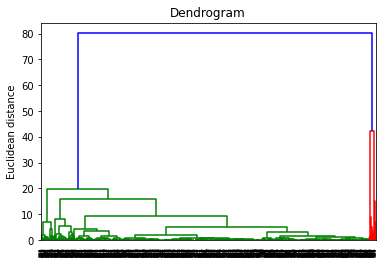

In [0]:
dendrogram = sch.dendrogram(sch.linkage(normalized_regr.iloc[:,:-1], method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

In [0]:
clustering = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [0]:
clust_test['Cluster'] = clustering.fit_predict(clust_test.iloc[:,:-1])

In [0]:
clust_test[clust_test['Cluster'] == 0]

,0,1,2,3,4,County,Cluster
51,-12.426123,12.838890,-13.191561,13.382798,-13.219328,"Apache, AZ",0
68,-2.092262,3.143165,-4.076415,4.886684,-5.605743,"Lincoln, AR",0
354,-2.961971,2.888197,-2.783114,2.658668,-2.578170,"Woodbury, IA",0
355,-8.849615,8.543867,-8.212965,7.890693,-7.750606,"Finney, KS",0
356,-4.913202,5.135440,-5.269888,5.317470,-5.340940,"Ford, KS",0
363,-2.948810,3.214382,-3.420851,3.583083,-3.780763,"Seward, KS",0
463,-7.432851,7.716991,-7.896584,8.014292,-8.256667,"Nobles, MN",0
470,-3.135534,2.960931,-2.773451,2.592775,-2.498483,"Stearns, MN",0
550,-4.205850,3.969911,-3.718384,3.472151,-3.326329,"Colfax, NE",0
551,-2.992689,3.075777,-3.110523,3.115255,-3.172308,"Dakota, NE",0


In [0]:
k = 3

In [0]:
partition = np.random.randint(0,k,len(county_lst))
partition = partition.tolist()

In [0]:
pi = [partition.count(i) for i in range(k)]